## Engineering Working Memory Network with Minimal or No Training: Linear

Consider a simple network where $K$ different stimuli is maintained during delay via fixed points. Here, $f$ returns a design of network with a desired set of fixed points. To be specific,

$$
f: \left( \mathbf{X}, \mathbf{Q} \right) \longrightarrow \left( \mathbf{W}^\ast_{\text{in}}, \mathbf{W}^\ast_{\text{rec}}, \mathbf{W}^\ast_{\text{out}}  \right)
$$

Given $(N\times K)$ matrix of tuned inputs $\mathbf{X}$,  $(M\times M)$ matrix of fixed points(eigenvectors)  $\mathbf{Q}$, the function returns the connectionity solutions $\displaystyle \mathbf{W}^\ast_{\text{in}}, \mathbf{W}^\ast_{\text{rec}}, \mathbf{W}^\ast_{\text{out}} $. 

In linear case(*i.e.* symmetric, deviation case), if $M > K$, then last $(M - K)$ eigenvectors are assumed spare ones. Often, they are technically needed in order to impose recurrence of $\mathbf{W}^\ast_{\text{rec}}$ ($M=K$ should result in an identity: that is, feed-forward network).

An input-to-identity mapping $\mathbf{W}_{\text{ID}}$. Possibly the mapping can be to non-identity, but in such cases the solution might not be exact.

Might be used for inferring connectivity from the observed fixed points.

In [131]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group # for generating orthonormal fixed points
from fixed_point_network import LinearFixedPointNetwork # linear fixed-point network
# from scipy.special import softmax

In [132]:
# det_rnn
sys.path.append('../') 
from det_rnn import Stimulus, par, update_parameters # det_rnn

par['strength_output'] = 1.
par['noise_sd']        = 0.5
par['noise_rnn_sd']    = 0.05
par['kappa']           = 12.
par['design'].update({'iti' : (0, 1.5),
                      'stim' : (1.5, 3.0),                      
                      'delay'   : ((3.0, 10.0),(11.5,16.0)),
                      'decision': (10.0, 11.5),  # no decision
                      'estim'   : (16.0, 17.5)})
par = update_parameters(par)

In [133]:
stimulus = Stimulus(par)
ti       = stimulus.generate_trial()
X        = stimulus.tuning_output[:,0,:]

In [134]:
M,N,K    = 40,24,24
W_ID     = np.zeros([K,N])
PEAKS    = np.linspace(0,N,num=K,endpoint=False,dtype=np.int)
for i in range(K): W_ID[i,PEAKS[i]] = 1
X        = X[:,PEAKS]

In [135]:
fpn_detrnn = LinearFixedPointNetwork(input_mat=X,par=par,identity_map=W_ID,encoding_dim=M,accumulation_rate=0.5)

In [136]:
Q     = ortho_group.rvs(M) # arbitrary orthonormal eigenvectors 
# Q     = np.random.rand((M,M))
fpn_detrnn.fit(Q)

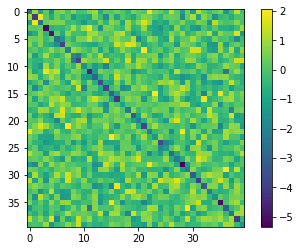

In [137]:
# Connectivity matrix
plt.imshow(fpn_detrnn.Wrec)
plt.colorbar()
plt.show()

In [138]:
# prediction
pred = fpn_detrnn.predict(ti['neural_input'][:,:,2:], apply_Wout=True)

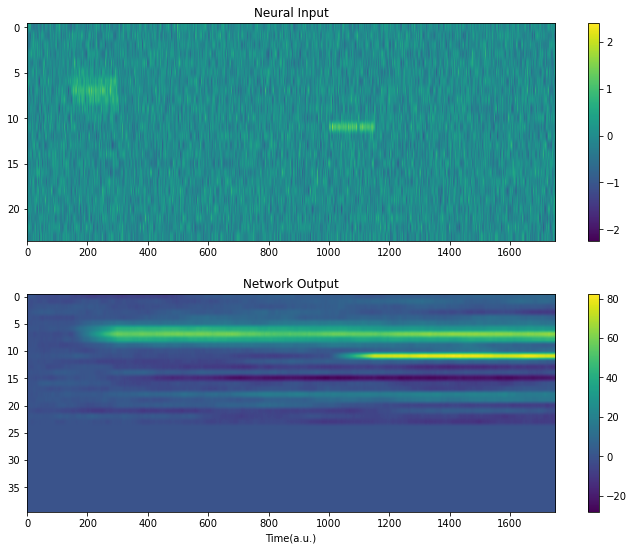

In [139]:
# 
TEST_TRIAL = np.random.randint(fpn_detrnn.batch_size)
fig, ax = plt.subplots(2,1, figsize=(10,8))
im0 = ax[0].imshow(ti['neural_input'][:,TEST_TRIAL,:][:,2:].T, aspect='auto'); ax[0].set_title("Neural Input"); plt.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(pred[:,:,TEST_TRIAL], aspect='auto'); ax[1].set_title("Network Output"); plt.colorbar(im1, ax=ax[1])
plt.xlabel("Time(a.u.)")
fig.tight_layout(pad=2.0)
plt.show()

### JsL version

In [113]:
randint = np.random.randint
nX, nT, nB = 4, 60, 128 # Number of stimulus category, time step, batch
nHidden = 120
par['len_hold']   = 20

#%% stimulus generation code
def gen_cat(x,t, nx, nt):
    y = np.zeros([nx+1, nt])
    t1s = np.cumsum(t)
    t0s = np.array([0] + list(t1s))
    
    for i, t0,t1 in zip(x, t0s,t1s):
        y[i,t0:t1] = 1
        
    return y[1:,:]

def generate_stim():
    xs = randint(1,nX+1,[nB,1])
    #stim_timing determine pre-stimulus time and stimulus duration
    stim_timings = np.concatenate(\
        [np.full_like(xs,0), # pre stimulus timing
        np.full_like(xs,30)], # stimulus duration
        axis = 1)

    # after stimulus presentation
    probe_timings = np.concatenate(\
        [randint(par['len_hold'], par['len_hold']+1, xs.shape), # holding timing
        np.full_like(xs,50)], # stimulus duration
        axis = 1)

    # generate stimulus
    X1, X2, X3 = [], [], []
    for x,st,pt in zip(xs, stim_timings, probe_timings):
        mt = np.concatenate([st,pt])
        #generate stimulus
        stim1 = gen_cat([0,x], st, nX, nT)
        #generate target
        targ1 = gen_cat([0,0,0,x], mt, nX, nT)
        #generate rule vector
        rule1 = gen_cat([1,2,1,3,1], 
                        np.array(list(mt)+[nT-sum(mt)]),
                        3, nT)
        rule1 = rule1[-1:,:]
        
        resp_time = np.sum(targ1, axis = 0)
        resp_init = np.where(np.diff(resp_time)==1)[0]
        
        spk_mask = np.int64((np.sum(stim1, axis = 0)+np.sum(targ1, axis = 0))==0).reshape((1,-1))
        perf_mask = np.zeros_like(spk_mask)
        perf_mask[:,(np.sum(st)+5):] = 1
        perf_mask[:,resp_time==1]  = 5
        perf_mask[:,np.arange(resp_init,resp_init+3)] = 0
        
        X1.append(np.concatenate([stim1, rule1], axis = 0)) # neural input stack
        X2.append(np.concatenate([targ1, (1-resp_time).reshape((1,-1))], axis = 0)) # desired output stack
        X3.append(np.concatenate([perf_mask, spk_mask], axis = 0))
        
    Input = np.stack(X1, axis = 0)
    Output = np.stack(X2, axis = 0)
    Mask = np.stack(X3, axis = 0)

    return Input, Output, Mask

Input, Output, Mask = generate_stim()

In [115]:
X        = np.eye(4)

In [116]:
M,N,K    = 12,4,4
W_ID     = np.zeros([K,N])
PEAKS    = np.linspace(0,N,num=K,endpoint=False,dtype=np.int)
for i in range(K): W_ID[i,PEAKS[i]] = 1
# X        = X[:,PEAKS]

In [118]:
fpn_dms = LinearFixedPointNetwork(input_mat=X,par=par,identity_map=W_ID,encoding_dim=M,accumulation_rate=0.5)

In [120]:
Q     = ortho_group.rvs(M) # arbitrary orthonormal eigenvectors 
# Q     = np.random.rand((M,M))
fpn_dms.fit(Q)

In [121]:
pred = fpn_dms.predict(Input[:,:4,:].transpose((2,0,1)), apply_Wout=True)

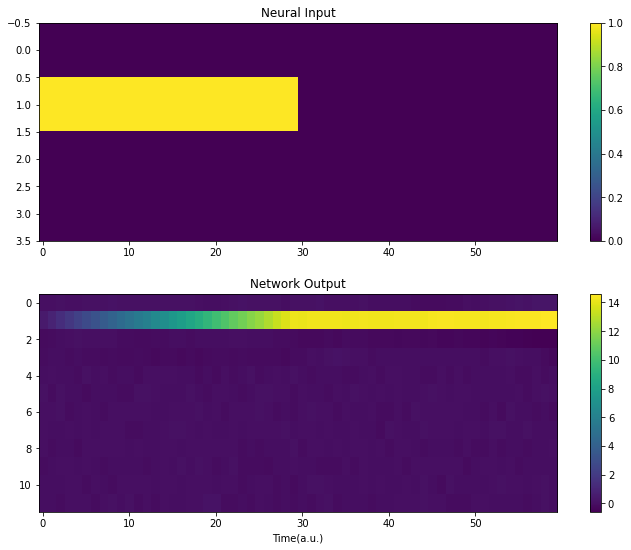

In [130]:
# 
TEST_TRIAL = np.random.randint(fpn_dms.batch_size)
fig, ax = plt.subplots(2,1, figsize=(10,8))
im0 = ax[0].imshow(Input[TEST_TRIAL,:,:][:4,:], aspect='auto'); ax[0].set_title("Neural Input"); plt.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(pred[:,:,TEST_TRIAL], aspect='auto'); ax[1].set_title("Network Output"); plt.colorbar(im1, ax=ax[1])
plt.xlabel("Time(a.u.)")
fig.tight_layout(pad=2.0)
plt.show()